simplebaseline 모델로 변경해 봅시다
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

STEP 1 : simplebaseline 모델 완성하기
simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

STEP 2 : simplebaseline 모델로 변경하여 훈련하기
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

STEP 3 : 두 모델의 비교
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

Pose Estimation 결과 시각화 (정성적 비교)
학습 진행 경과 (loss 감소 현황)
가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

In [1]:
import tensorflow as tf
print(tf.__version__)  
print(tf.test.is_built_with_cuda())  
print(tf.config.list_physical_devices('GPU'))  

2.6.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = './'
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')


Matplotlib is building the font cache; this may take a moment.


In [3]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [4]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation


In [5]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [6]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


In [7]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results



In [8]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [9]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [10]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


In [11]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-03-18 22:46:09,957	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=153) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=153) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=151) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=151) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=152) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=152) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=153) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=153) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=151) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=151) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=152) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=152) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=153) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=153) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=151) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=151) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

In [12]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


In [13]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

(build_single_tfrecord pid=152) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords
슝=3


In [14]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


In [15]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


In [16]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [17]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [18]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [19]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


In [20]:
import datetime
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        # 타임스탬프 추가하여 고유 파일 이름 생성
        timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_name = os.path.join(MODEL_PATH, f"model1-epoch-{epoch}-loss-{loss:.4f}-{timestamp}.h5")
        self.model.save_weights(model_name)
        self.best_model = model_name
        print(f"Model saved at {model_name}")

print('슝=3')

슝=3


In [21]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [22]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)


train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

simple baseline

In [23]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [24]:
upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

In [25]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)

In [26]:
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [27]:
inputs = keras.Input(shape=(256, 256, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model1 = keras.Model(inputs, out)

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [28]:
def train1(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        # 기존에 정의한 model1을 클론하여 전략 내에서 재생성합니다.
        model = tf.keras.models.clone_model(model1)
        model.set_weights(model1.get_weights())
        
        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)
        
        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)



train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file1 = train1(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

In [31]:
for batch in create_dataset(tfrecords, batch_size, num_heatmap, is_train=True).take(1):
    images, labels = batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


NameError: name 'tfrecords' is not defined

In [35]:
np_input = np.zeros((1,256,256,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model1(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

input shape
(1, 256, 256, 3)


output shape
(1, 64, 64, 16)
tf.Tensor(
[[[ 1.74441864e-03  5.55541366e-03 -9.54276300e-04 -2.36080959e-03
   -4.65864874e-03 -2.35418673e-03 -1.56114023e-04 -1.95214374e-03
    5.99500025e-03  1.67404825e-03]
  [ 7.51942815e-03  6.90590777e-03 -4.20734007e-03 -7.93446973e-03
    4.12045093e-03 -4.66624089e-03 -6.09223871e-03  5.89407689e-04
    8.08695145e-03 -6.45737024e-03]
  [ 4.81531862e-03  7.95337837e-03  6.71212282e-03  1.80588139e-03
   -5.13044698e-03 -4.83248383e-03 -8.21583439e-03 -1.76066421e-02
    5.17989183e-03  1.58297475e-02]
  [-1.20902504e-03 -8.46465409e-04  4.01893863e-03 -6.05465518e-03
    2.54050852e-03 -1.03720976e-02 -1.28161826e-03  1.63615635e-03
    1.25992885e-02  1.19326585e-04]
  [ 1.45896496e-02  4.34184400e-03 -6.07001083e-03 -4.55337437e-03
   -1.37248179e-02  1.15765352e-02 -1.14858919e-03 -4.29224828e-03
    9.57894977e-03  1.86738931e-02]
  [ 1.49133531e-02  5.73483063e-03  1.25498557e-02 -1.29246749e-02
    2.550153

In [39]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'model-epoch-5-loss-1.1878.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

WEIGHTS_PATH1 = os.path.join(PROJECT_PATH, 'model1-epoch-5-loss-6.2974-20250318-093915.h5')

model1 = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model1.load_weights(WEIGHTS_PATH1, by_name=True)



In [40]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [41]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [42]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [43]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [44]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


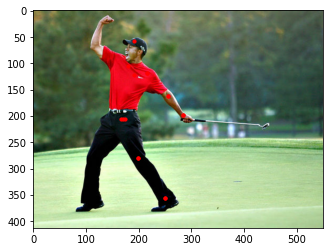

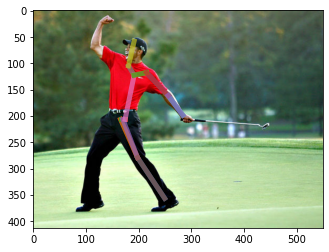

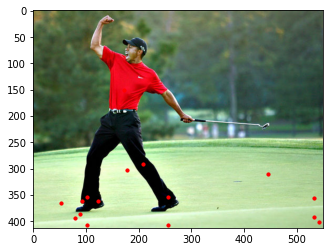

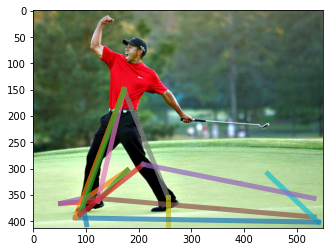

In [45]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

image, keypoints = predict(model1, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

Simplebaseline 모델 학습이 실패하였습니다....
loss 값을 보면 6.대로 수렴하는데 모델빌드에서 뭔가 잘못 건드린 것 같습니다. 다른분들도 비슷한 문제를 가지고 있는데 공통점을 찾아서 토의해서 해결해야 할 것 같습니다.

예상 : heatmap 16 으로 설정되서 마지막 레이어 채널도 16으로 변경(원래는 17), inputsize 변경



# 회고록

노드에 따라서 GPU를 배정하는 것을 처음 알았다. 다음에는 이런일이 없도록 해야겠다.

못한점, 보충해야 할 점 : 시간 문제상 오버피팅을 확인하거나 옵티마이저나 하이퍼파라미터 설정을 좀 더 보지 못했다.

해야할 것들 : 수어인식도 face detection이나 human pose에서 응용된 점이라고 느껴진다. 좀 더 발전해서 공부해야겠다.

simple_baseline loss가 6.~ 대로 수렴하는데 이것은 문제가 있다. 인수님은 resnet에서 downsampling을 너무 많이 해서 그렇다고 의견을 주셨는데 좀 더 시간을 쓰고 왜 그런지 토의해봐야 겠다.

노드랑 다르게한점 : Heatmap이 16으로 설정되어 있어서 마지막층 채널을 16으로 수정, input_shape을 앞선 모델과 같게 설정(resize를 다르게 해야하는건가? 그러면 비교가 가능한가?)